# Introduction to Contemporary Machine Learning

##  2024 University of Sydney Hunstead Tutorial 3
### Bryan Scott, CIERA | Northwestern University

Based on tutorials from LSST DA Data Science Fellowship Program Session 19: Machine Learning held at Drexel University in Philadelphia, Pennsylvania, United States

## Problem 1: Bayes Classifiers

A good starting point for Machine Learning is the Bayes classifier. The basic idea is to assign the most probable label to each data point using Bayes theorem, we take:

$$
p(y | x_n) \propto p(y)p(x_i, ..., x_n | y)
$$

where y is a label for a data point and the $x_n$ are the features of the data that we want to use to classify each data point. A $\textit{Naive} Bayes$ classifier makes an important simplifying assumptions that gives it the name - it assumes that the conditional probabilities are independent, $p(x_i, ..., x_n | y) = p(x_i|y)... p(x_n | y)$. That is, the probability of observing any individual feature doesn't depend on any of the other features. Our task is to construct this classifier from a set of examples we've observed previously and compare it to new data. 

### Part 0: Load and split the data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

### Loading and splitting the data. 

Read in the data, then start by selecting the id, fluxes, and object truth type in the lsst data file you've been provided. 

Once you have selected those, randomly split the data into two arrays, one containing 80% of the data, and a second array containing 20% of the data. 

In [2]:
lsst_data = pd.read_csv('table_data.lsst.cloudapi.csv')

# solved 

lsst_data_to_classify = lsst_data[['id', 'flux_g', 'flux_i', 'flux_r', 'flux_u', 'flux_y', 'flux_z', 'truth_type']]
random_data = lsst_data_to_classify.sample(n=1000)

train_data = random_data[:800]
test_data = random_data[800:]

In [78]:
random_data[random_data['truth_type'] == 1]

,id,flux_g,flux_i,flux_r,flux_u,flux_y,flux_z,truth_type
43574,11701736113,24.53890,29.13250,27.93080,13.63390,73.94030,44.51080,1
38978,11700776677,19.53990,18.25040,19.30870,14.49830,19.52230,18.88810,1
14277,11579106399,9.00237,8.15582,8.76534,7.52316,7.32248,7.59945,1
34673,11689343323,6.27635,21.95360,9.77728,4.80588,28.58890,27.93140,1
34453,11702877831,138.91200,116.57600,130.07400,118.84100,99.36330,105.76400,1
...,...,...,...,...,...,...,...,...
23675,11627782560,36.20480,113.69200,63.47950,26.68860,283.16100,238.43100,1
26783,11630429711,36.84910,35.82170,34.63700,37.21890,60.60580,36.91980,1
35804,11690001294,96.83740,500.48300,222.49900,64.43040,1164.93000,981.29600,1
15175,11571449891,12.34000,11.68970,12.08130,10.54730,12.24560,12.20970,1


### Part 1: Estimate Class Frequency in the training set

One of the ingredients in our classifier is p(y), the unconditional class probabilities. 

We can get this by counting the number of rows belonging to each class in train_data and dividing by the length of the training data set. 

In [3]:
# solved

def estimate_class_probabilities(x_train): 
    """
    Computes unconditional class probabilities. 
     
    Args:
        x_train (array): training data for the classifier
 
    Returns:
        ints p1, p2: unconditional probability of an element of the training set belonging to class 1
    """
    
    p1 = x_train['truth_type'].value_counts()[1] / len(x_train)
    p2 = x_train['truth_type'].value_counts()[2] / len(x_train)
    
    return p1, p2

p1, p2 = estimate_class_probabilities(test_data)


### Part 2:  Feature Likelihoods

We are assuming that the relationship between the classes and feature probabilities are related via:

$p(x_i, ..., x_n | y) =  p(x_i|y)... p(x_n | y)$

however, we still need to make an assumption about the functional form of the $p(x_n | y)$. As a simple case, we will assume p(x_n | y) follows a Gaussian distribution given by:

$$
p(x_i | y) = \frac{1}{\sqrt{2 \pi \sigma_y}} \exp{\left(-\frac{(x_i - \mu)^2}{\sigma_y^2}\right)}
$$

and we will make a maximum likelihood estimate of $\mu$ and $\sigma_y$ from the data. This means using empirical estimates $\bar{x}$ and $\hat{\sigma}$ as estimators of the true parameters $\mu$ and $\sigma_y$. 

Write a fitting function that takes the log of the fluxes and returns an estimate of the parameters of the per-feature likelihoods for each class.

In [4]:
# solved

def per_feature_likelihood_parameters(x_train):
    """
    Computes MAP estimates for the class conditional likelihood. 
     
    Args:
        x_train (array or pd series): training data for the classifier
        label (int): training labels for the classifier 
 
    Returns:
        means, stdevs (array): MAP estimates of the Gaussian conditional probability distributions for a specific class
    """
    
    keys = ['flux_g', 'flux_i', 'flux_r', 'flux_u', 'flux_y', 'flux_z']

    flag_1 = x_train['truth_type'] == 1
    means_1 = np.log(x_train[keys][flag_1]).mean()
    stdevs_1 = np.log(x_train[keys][flag_1]).std()

    flag_2 = x_train['truth_type'] == 2
    means_2 = np.log(x_train[keys][flag_2]).mean()
    stdevs_2 = np.log(x_train[keys][flag_2]).std()

    results = {'means_1':means_1, 'stdevs_1':stdevs_1, 'means_2':means_2, 'stdevs_2':stdevs_2}
    
    return results



### Part 3: MAP Estimates of the Class Probabilities

Now that we have the unconditional class probabilities and the parameters of the per feature likelihoods in hand, we can put this all together to build the classifier. Use the methods you have already written to write a function that takes in the training data and returns fit parameters. Once you have done that, write a method that takes the fit parameters as an argument and predicts the class of new (and unseen) data. 

In [5]:
# build the classifier

# solved 

def fit(x_train):
    """
    Convenience function to perform fitting on the training data
     
    Args:
        x_train (array or pd series): training data for the classifier
 
    Returns:
        p1, p2, class_1_mean, class_2_mean, class_1_std, class_2_std: see documentation for per_feature_likelihood_parameters
    """
    
    p1, p2 = estimate_class_probabilities(x_train)
    
    results_means_stdevs = per_feature_likelihood_parameters(x_train)
    
    return [p1, p2], results_means_stdevs

In [6]:
class_probability, class_means_std = fit(train_data)

In [7]:
# solved 

def predict(x_test, class_probability, class_means_std):
    """
    Predict method
     
    Args:
        x_test (array): data to perform classification on
        class_probability (array): unconditional class probabilities
        class_means, class_dev (array): MAP estimates produced by the fit method
 
    Returns:
        predict_List (list): class membership predictions
    """
    
    mag_g, mag_r, mag_i, mag_u, mag_y = np.log(np.array(x_test[['flux_g', 'flux_r', 'flux_i', 'flux_u', 'flux_y']])).T

    prob_1 = class_probability[0]
    prob_2 = class_probability[1]
    
    predict_list = np.zeros(len(x_test))

    class_probability, class_means_std = fit(x_test)

    def calculate_log_likelihood(mag_array, class_means_std):
        # note this multiplies the likelihoods (based on Gaussians) of each feature, 
        # which in log space is addition
        log_likelihood_1 = 0
        log_likelihood_2 = 0
        
        for i in range(len(mag_array)):
            log_likelihood_1 += -0.5*np.log(2*np.pi*class_means_std['stdevs_1'][i]**2) - (mag_array[i]-class_means_std['means_1'][i])**2/(2*class_means_std['stdevs_1'][i]**2)
            log_likelihood_2 += -0.5*np.log(2*np.pi*class_means_std['stdevs_2'][i]**2) - (mag_array[i]-class_means_std['means_2'][i])**2/(2*class_means_std['stdevs_2'][i]**2)
        return log_likelihood_1, log_likelihood_2

    for i in range(0, len(x_test)):

        log_likelihood_1, log_likelihood_2 = calculate_log_likelihood([mag_g[i], mag_r[i], mag_i[i], mag_u[i], mag_y[i]], class_means_std)

        # posteriors 
        prob_class_1 = prob_1 * np.exp(log_likelihood_1)
        prob_class_2 = prob_2 * np.exp(log_likelihood_2)

        if prob_class_1 > prob_class_2:
            predict_list[i] = 1
        else:
            predict_list[i] = 2
    
    return predict_list

In [8]:
test_data = test_data[~(test_data == 0).any(axis = 1)]

In [9]:
results_predict = predict(test_data, class_probability, class_means_std)

/var/folders/r9/vf1sqnrn01n0nzmbl59dbqjc0000gn/T/ipykernel_4549/1514556701.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  log_likelihood_1 += -0.5*np.log(2*np.pi*class_means_std['stdevs_1'][i]**2) - (mag_array[i]-class_means_std['means_1'][i])**2/(2*class_means_std['stdevs_1'][i]**2)
/var/folders/r9/vf1sqnrn01n0nzmbl59dbqjc0000gn/T/ipykernel_4549/1514556701.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  log_likelihood_2 += -0.5*np.log(2*np.pi*class_means_std['stdevs_2'][i]**2) - (mag_array[i]-class_means_std['means_2'][i])**2/(2*class_means_std['stdevs_2'][i]**2)


### Part 4: Metrics

After creating a classifier, you now want to evaluate it in terms of how often it correctly and incorrectly classifies the objects in your training set. To do this, we'll design a confusion matrix. A confusion matrix is a matrix whose entries are the counts of the predicted vs actual class. For example, the first entry is the count of objects that are predicted to be of class 1 and actually are of class 1 and so on, while the off-diagonal elements would be instances of class 1 that are predicted to be of class 2, and instances of class 2 that are predicted to be of class 1. 

In [10]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


In [11]:
df_confusion = pd.crosstab(test_data['truth_type'] ,predict(test_data, class_probability, class_means_std))

/var/folders/r9/vf1sqnrn01n0nzmbl59dbqjc0000gn/T/ipykernel_4549/1514556701.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  log_likelihood_1 += -0.5*np.log(2*np.pi*class_means_std['stdevs_1'][i]**2) - (mag_array[i]-class_means_std['means_1'][i])**2/(2*class_means_std['stdevs_1'][i]**2)
/var/folders/r9/vf1sqnrn01n0nzmbl59dbqjc0000gn/T/ipykernel_4549/1514556701.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  log_likelihood_2 += -0.5*np.log(2*np.pi*class_means_std['stdevs_2'][i]**2) - (mag_array[i]-class_means_std['means_2'][i])**2/(2*class_means_std['stdevs_2'][i]**2)


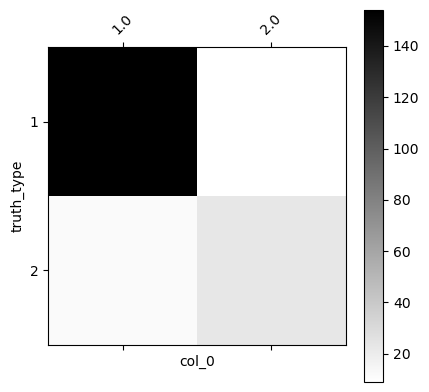

In [12]:
plot_confusion_matrix(df_confusion)

## Problem 2) Generic Perceptron

This is a lightly modified version of a problem originally written by Adam Miller (Northwestern).

Perceptrons are a type of articifical neuron. We will construct a basic neuron in pure python today and use it to classify data in a "simple" two class problem. 

A representation of a perceptron is given by $w_n \cdot x_n = \sum_n w_n x_n$. Each perceptron also has an activation threshold, called a bias, b: 

$$\mathrm{output} = \left\{ \begin{array}{lcr}
0 & \mathrm{if} \; w_n \cdot x_n + b & \le 0 \\
1 & \mathrm{if} \; w_n \cdot x_n + b & > 0
\end{array}\right.
$$

Now, build a generic perceptron that can take any collection of input signals and weights, as well as a bias, to determine the binary output from the artificial neuron.

**Problem 2a**

Write a generic function `perceptron` that takes as input arrays called `signals` and `weights` as well as a float called `bias`. The function should return a boolean indicating whether or not the perceptron is "activated". 

In [ ]:
def perceptron(signals, weights, bias): 
    '''Generic perceptron function
    
    Parameters
    ----------
    signals : array-like
        the input signals for the perceptron
        
    weights : array-like
        the weight applied to each input
        
    bias : float
        the value required for activation
        
    Returns
    -------
    activated : bool
        whether or not the perceptron is activated
    '''
    
    activated = 
    return activated

**Problem 2b** 

Is the perceptron activated if the signal = [2.3, 5.3, 1.2, 3.4], the weights = [-3, 2, 0.5, -1], and no bias (i.e., bias = 0)?

**Problem 2c** 

What if the signal and weights do not change but the bias = -2? 

**Problem 2d**

For a perceptron, training means updating the weights to better reflect the training data. 

Here's the pseudo-code: 
  1. Apply the perceptron to one of the data points
  2. Adjust the weights and the bias if the perceptron makes an incorrect classification
  3. Repeat this procedure over all N datapoints
  4. Repeat this procedure for M iterations
  
How do we adjust the weights? For every sample we evaluate the model error (is the classification correct or not). We then adjust the weight to reduce the error for the following prediction. 

For a perceptron, these updates can be calculated simply as: 

$$w_\mathrm{updated} = w_\mathrm{current} + \eta\,\, (y_\mathrm{true} - y_\mathrm{pred})\,\, x,$$

$$b_\mathrm{updated} = b_\mathrm{current} + \eta\,\, (y_\mathrm{true} - y_\mathrm{pred})$$

where $w_\mathrm{updated}$ is the new value for the weight, $w_\mathrm{current}$ is the current value for the weight, $b_\mathrm{updated}$ is the new value for the bias, $b_\mathrm{current}$ is the current value for the bias, $\eta$ is the called the *learning rate*, $x$ is the value of the input signal, and $(y_\mathrm{true} - y_\mathrm{pred})$ captures whether or not the classification was correct.



Write a function `train_perceptron` that accepts as input `X`, `y`, `weights`, `bias`, `epochs`, and `learning rate`. The function should train the perceptron for $M$ epochs. During each epoch, the weights and bias should be updated using the equation given above while looping over every source in the training set. 

*Hint* – it is useful to track the number of misclassifications that occur during each epoch. 

*Hint 2* – for this problem we only care about training, but if you eventually wanted to classify data with the perceptron then you would need to extract the weights and bias from the function, or, even better, write the perceptron as a class object that be trained and also classify (similar to scikit-learn). 

In [ ]:
def train_perceptron(X, y, weights, bias=0, epochs=5, learning_rate=0.01): 
    '''Train a perceptron to classify binary labels via numerical features
    
    Parameters
    ----------
    X : array-like
        Feature array for the data, in the style of scikit-learn
    y : array-like, type = bool
        Label array for the data
    weights : array-like
        Weights for the input signals to the perceptron
    bias : array-like
        Bias value for the perceptron
    epochs : int
        Number of instances for training the perceptron
    learning_rate : float
        Relative step size for tuning the weights and bias
    '''
    w_updated = weights
    bias_updated = bias
    misclassified = 0
    for signal, true in zip(X, y): 
        activated = 
        error = 
        misclassified += 
    print(f'For initial weights, accuracy = {(len(y)-misclassified)/len(y):.4f}')
    for epoch in range(epochs): 
        misclassified = 0
        for signal, true in zip(X, y): 
            activated = 
            error = 
            misclassified += 
            for i in range(len(weights)):
                w_updated[i] = 
            bias_updated = 
            
        print(f'For epoch {epoch}, accuracy = {(len(y)-misclassified)/len(y):.4f}')


To demonstrate how this works we will generate some synthetic two-dimensional data, but the principle can easily be scaled to an arbitrarily large number of dimensions. 

We use `scikit-learn` to simulate two classes in a 2d plane using the [`make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function. We will only include 30 samples so the data are easy to visualize.

In [ ]:
from sklearn.datasets import make_blobs

In [ ]:
X, y = make_blobs(n_samples=30, centers=2, n_features=2,
                  center_box = (0,4), random_state=1885)

fig, ax = plt.subplots()
activated = y == 1
ax.plot(X[activated,0], X[activated,1], 'o', 
        ms = 9, mew=2, mfc='None')
ax.plot(X[~activated,0], X[~activated,1], '+', 
        ms=15, mew=2)
ax.set_xlabel('X1', fontsize=15)
ax.set_ylabel('X2', fontsize=15)
fig.tight_layout()

Train the perceptron. Use weights of [.1, 1], a bias of 0, train for 20 epochs, with a learning rate $\eta = 0.005$.

Adjust the weights, or bias, or number of epochs, or learning rate, or all of them, to see how the changes affect the output of the perceptron. 

What do you notice as these changes are made?


## Challenge Problem: Representation Learning and Anomaly Detection

Discovery through Eingenbasis Modelling of Uninteresting Data (DEMUD) is an intuitive approach to the anomaly detection problem which depends only on fast matrix algebra, and can therefore be done for large datasets without too many computational challenges. I will not provide a solution aside from noting that an efficient implementation is found here: https://github.com/wkiri/DEMUD?tab=readme-ov-file but I would encourage you to attempt to implement this on your own since it illustrates many of the core concepts in anomaly detection and representation learning from a classical machine learning perspective. I intend to add this to a future Data Science Fellowship Program tutorial, so if you attempt this, please provide feedback that can inform that lesson! 

The basic idea is to take a dataset and *iteratively* build an eigenbasis model of the data using the *Singular Value Decomposition (SVD)*. Given this model, take data that didn't participate in the construction of the model and compute the reconstruction error of the data. Small reconstruction errors represent data that is well explained by the model, while large reconstruction errors have the potential to be anomalous on the model. Now update the model given the data that remains interesting. 

An algorithm for doing this is given below. This is taken from https://wkiri.com/research/papers/wagstaff-demud-13.pdf, which introduced this approach and later demonstrated it for data from NASA Mars missions and for image analysis,

1. Let X be an input data set represented as an nxd matrix (n rows of data, of d dimensions)
2. Initialize an empty set of uninteresting data $X_u = \emptyset$
3. Choose a value for k, the number of principle components that will be used to represent the data. 
4. Compute the Singular Value Decomposition (U, $\mu$) of X in terms of k principal components

Looping over elements of the input dataset $x \in X$;

5. Each data point x can now be reconstructed from this learned representation via  $\hat{x} = UU^T (x − \mu) + \mu$ (this is a reconstruction of the datapoint $x \in X$ in the representation retaining k-principal components)  
6. Compute the error in the reconstruction $|| x - \hat{x} ||_2$
7. Select the datapoint with the largest reconstruction error. Call this x'. Save the reconstruction error as an explanation of the anomaly represented by the data points. 
8. Remove x' from the set of data used to construct the model. Add x' to $X_u$. 

The clever part comes next. When $X_u$ has a single object, the model is then trained on this single datapoint. Now at each subsequent step, add the greatest reconstruction error x' relative to the current model to the set of $X_u$, and 
9. Compute the SVD of ${X_u, x'}$ relative for k-componets. 
10. Continue this process for each x until exhaustion. 

This algorithm shares a common feature with many classical anomaly detection/representation learning approaches in that it says that data which is initially picked out relative to some reconstruction score are likely to be anomalous or worthy of follow up. Something similar is seen with isolation forests, for example, which select data that leads to a split in the tree early on as containing more novel information that later splits. 